# Machine Learning Model Architecture

## Construction of Test/Train datasets

In [1]:
import pandas as pd
from keras import layers, models, optimizers
# Let's make sure these directories are clean before we start
import shutil
try:
    shutil.rmtree("../data/project3/data_all_modified/data_split/train")
    shutil.rmtree("../data/project3/data_all_modified/data_split/test")
except:
    pass

/tmp/ipykernel_6415/3949959727.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-04-11 15:29:40.595097: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 15:29:40.655860: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 15:29:40.655932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin 

In [2]:
# We have two classes which contains all the data: Damage & No_damage
# Let's create directories for each class in the train and test directories.
import os
# ensure directories exist
from pathlib import Path

Path("../data/project3/data_all_modified/data_split/test/damage").mkdir(parents=True, exist_ok=True)
Path("../data/project3/data_all_modified/data_split/test/no_damage").mkdir(parents=True, exist_ok=True)

Path("../data/project3/data_all_modified/data_split/train/damage").mkdir(parents=True, exist_ok=True)
Path("../data/project3/data_all_modified/data_split/train/no_damage").mkdir(parents=True, exist_ok=True)

In [3]:
# we need paths of images for individual classes so we can copy them in the new directories that we created above
all_damage_file_paths = os.listdir('../data/project3/data_all_modified/damage')
all_no_damage_file_paths = os.listdir('../data/project3/data_all_modified/no_damage')

In [4]:
import random

train_damage_paths = random.sample(all_damage_file_paths, int(len(all_damage_file_paths)*0.8))
print("train Damage image count: ", len(train_damage_paths))
test_damage_paths = [ p for p in all_damage_file_paths if p not in train_damage_paths]
print("test Damage image count: ", len(test_damage_paths))
# ensure no overlap:
overlap = [p for p in train_damage_paths if p in test_damage_paths]
print("len of overlap: ", len(overlap))

train_no_damage_paths = random.sample(all_no_damage_file_paths, int(len(all_no_damage_file_paths)*0.8))
print("train No Damage image count: ", len(train_no_damage_paths))
test_no_damage_paths = [ p for p in all_no_damage_file_paths if p not in train_no_damage_paths]
print("test No Damage image count: ", len(test_no_damage_paths))
# ensure no overlap:
overlap = [p for p in train_no_damage_paths if p in test_no_damage_paths]
print("len of overlap: ", len(overlap))

train Damage image count:  11336
test Damage image count:  2834
len of overlap:  0
train No Damage image count:  5721
test No Damage image count:  1431
len of overlap:  0


In [5]:
#ensure to copy the images to the directories
import shutil
for p in train_damage_paths:
    shutil.copyfile(os.path.join('../data/project3/data_all_modified/damage', p), os.path.join("../data/project3/data_all_modified/data_split/train/damage", p) )

for p in test_damage_paths:
    shutil.copyfile(os.path.join('../data/project3/data_all_modified/damage', p), os.path.join("../data/project3/data_all_modified/data_split/test/damage", p) )

for p in train_no_damage_paths:
    shutil.copyfile(os.path.join('../data/project3/data_all_modified/no_damage', p), os.path.join("../data/project3/data_all_modified/data_split/train/no_damage", p) )

for p in test_no_damage_paths:
    shutil.copyfile(os.path.join('../data/project3/data_all_modified/no_damage', p), os.path.join("../data/project3/data_all_modified/data_split/test/no_damage", p) )

# check counts:
print("Files in train/damage: ", len(os.listdir("../data/project3/data_all_modified/data_split/train/damage")))
print("Files in train/no_damage: ", len(os.listdir("../data/project3/data_all_modified/data_split/test/damage")))

print("Files in test/damage: ", len(os.listdir("../data/project3/data_all_modified/data_split/train/no_damage")))
print("Files in test/no_damage: ", len(os.listdir("../data/project3/data_all_modified/data_split/test/no_damage")))

Files in train/damage:  11336
Files in train/no_damage:  2834
Files in test/damage:  5721
Files in test/no_damage:  1431


## Data Pre-Processing

In [6]:
# Using PIL to get image dimensions
from PIL import Image

def get_image_dimensions(image_path: str):
    '''
    Gets image dimensions through the input of a directory

    Input: Takes string input of the directory path to an image

    Output: Returns image dimensions of height & width pixels
    '''
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            return width, height
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

def check_images_same_size(directory: str):
    '''
    Ensures that all images within a directory are the same size

    Input: Takes a string input of the desired directory to be check

    Output: Prints a statement stating images are the same size & their dimensions,
            or prints that the images have different sizes, or that there werent any valid images in
            the directory.
    '''
    dimensions_set = set()  # To store unique dimensions of images
    for filename in os.listdir(directory):
        if filename.endswith(".jpeg"):
            image_path = os.path.join(directory, filename)
            dimensions = get_image_dimensions(image_path)
            if dimensions:
                dimensions_set.add(dimensions)

    if len(dimensions_set) == 1:
        dimensions = dimensions_set.pop()
        print("All images are the same size.")
        print(f"Image dimensions: {dimensions[0]}x{dimensions[1]} pixels")
    elif len(dimensions_set) > 1:
        print("Images have different sizes.")
    else:
        print("No valid images found in the directory.")

In [7]:
train_data_dmg = '../data/project3/data_all_modified/data_split/train/damage'
train_data_no_dmg = '../data/project3/data_all_modified/data_split/train/no_damage'
check_images_same_size(train_data_dmg)
check_images_same_size(train_data_no_dmg)

All images are the same size.
Image dimensions: 128x128 pixels
All images are the same size.
Image dimensions: 128x128 pixels


In [ ]:
#pip install tensorflow_datasets --user

In [8]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
# Now that we know the image dimensions
train_data_dir = '../data/project3/data_all_modified/data_split/train'
# Number of images we want to process at once
batch_size = 64

# Target image size (128 px by 128 px)
img_height = 128
img_width = 128
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
train_data_dir,
validation_split=0.2,
subset="both",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size
)
rescale = Rescaling(scale=1.0/255)
train_rescale_ds = train_ds.map(lambda image,label:(rescale(image),label))
val_rescale_ds = val_ds.map(lambda image,label:(rescale(image),label))

Found 17057 files belonging to 2 classes.
Using 13646 files for training.
Using 3411 files for validation.


In [9]:
test_data_dir = '../data/project3/data_all_modified/data_split/train'

batch_size = 2

img_height = 128
img_width = 128

# note that subset="training", "validation", "both", and dictates what is returned
test_ds = tf.keras.utils.image_dataset_from_directory(
test_data_dir,
seed=123,
image_size=(img_height, img_width),
)

rescale = Rescaling(scale=1.0/255)
test_rescale_ds = test_ds.map(lambda image,label:(rescale(image),label))

Found 17057 files belonging to 2 classes.


## A Dense ANN Model

In [11]:
# Building a CNN with 3 alternating convolutional layers & pooling layers
# with 2 dense hidden layers. Output layer has 3 classes & softmax activation

dimen = img_height * img_width * 3

# initialize sequential model
model_ann = models.Sequential()

# Flattening of input data for the dense layers
model_ann.add(layers.Flatten(input_shape = (img_height,img_width,3)))

# Adding inital dense layer with 256 perceptrons
model_ann.add(layers.Dense(256, activation = 'relu'))

# Adding a fully connected dense layer with 128 perceptrons
model_ann.add(layers.Dense(128, activation='relu'))

# Adding a fully connected dense layer with 64 perceptrons
model_ann.add(layers.Dense(64, activation='relu'))

# Adding a fully connected dense layer with 32 perceptrons
model_ann.add(layers.Dense(32, activation='relu'))

# Adding a fully connected dense layer with 16 perceptrons
model_ann.add(layers.Dense(16, activation='relu'))

# Adding a fully connected dense layer with 8 perceptrons
model_ann.add(layers.Dense(8, activation='relu'))

# Adding the output layer with 2 neuron and 
# activation functions as sigmoid since this is a binary classification problem
model_ann.add(layers.Dense(2, activation='sigmoid'))

In [12]:
# Compile model
# RMSprop (Root Mean Square Propagation) is commonly used in training deep neural networks.
model_ann.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

# Generating the summary of the model
model_ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 256)               12583168  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 8)                 1

In [13]:
#fit the model from image generator
history = model_ann.fit(
            train_rescale_ds,
            batch_size=64,
            epochs= 100,
            validation_data=val_rescale_ds
)

Epoch 1/100
214/214 [==============================] - 15s 63ms/step - loss: 0.6512 - accuracy: 0.6575 - val_loss: 0.6578 - val_accuracy: 0.6681
Epoch 2/100
214/214 [==============================] - 15s 71ms/step - loss: 0.6187 - accuracy: 0.6634 - val_loss: 0.5940 - val_accuracy: 0.6681
Epoch 3/100
214/214 [==============================] - 16s 76ms/step - loss: 0.6034 - accuracy: 0.6675 - val_loss: 0.5775 - val_accuracy: 0.6992
Epoch 4/100
214/214 [==============================] - 16s 76ms/step - loss: 0.5856 - accuracy: 0.7020 - val_loss: 0.7658 - val_accuracy: 0.6705
Epoch 5/100
214/214 [==============================] - 17s 81ms/step - loss: 0.5757 - accuracy: 0.7122 - val_loss: 0.5720 - val_accuracy: 0.7318
Epoch 6/100
214/214 [==============================] - 18s 83ms/step - loss: 0.5670 - accuracy: 0.7231 - val_loss: 0.5808 - val_accuracy: 0.7083
Epoch 7/100
214/214 [==============================] - 18s 82ms/step - loss: 0.5594 - accuracy: 0.7278 - val_loss: 0.5751 - val_ac

In [14]:
test_loss, test_accuracy = model_ann.evaluate(test_rescale_ds, verbose = 0)
# validation accuracy
print(f'Test Loss: {test_loss}')
# test accuracy
print(f'Test Accuracy: {test_accuracy}')

Test Loss: 0.3912183940410614
Test Accuracy: 0.8430556654930115


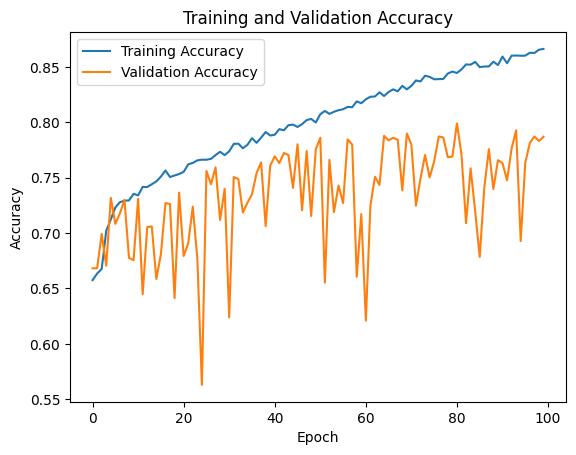

In [15]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## LeNet-5 Architecture

In [10]:
model_lenet5 = models.Sequential()

# Layer 1: Convolutional layer with 6 filters of size 3x3, followed by average pooling
model_lenet5.add(layers.Conv2D(6, kernel_size=(3, 3), activation='relu', input_shape=(img_height,img_width,3)))
model_lenet5.add(layers.AveragePooling2D(pool_size=(2, 2)))

# Layer 2: Convolutional layer with 16 filters of size 3x3, followed by average pooling
model_lenet5.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu'))
model_lenet5.add(layers.AveragePooling2D(pool_size=(2, 2)))

# Flatten the feature maps to feed into fully connected layers
model_lenet5.add(layers.Flatten())

# Layer 3: Fully connected layer with 120 neurons
model_lenet5.add(layers.Dense(120, activation='relu'))

# Layer 4: Fully connected layer with 84 neurons
model_lenet5.add(layers.Dense(84, activation='relu'))

# Output layer: Fully connected layer with num_classes neurons (e.g., 1 )
model_lenet5.add(layers.Dense(2, activation='sigmoid'))

# Compile model
model_lenet5.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), 
                     loss='sparse_categorical_crossentropy', 
                     metrics=['accuracy'])

# Generating the summary of the model
model_lenet5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 6)       168       
                                                                 
 average_pooling2d (Average  (None, 63, 63, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 16)        880       
                                                                 
 average_pooling2d_1 (Avera  (None, 30, 30, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 14400)             0         
                                                                 
 dense (Dense)               (None, 120)               1

In [18]:
history2 = model_lenet5.fit(
            train_rescale_ds,
            batch_size=64,
            epochs=100,
            validation_data=val_rescale_ds
)

Epoch 1/100
214/214 [==============================] - 22s 99ms/step - loss: 0.5900 - accuracy: 0.6990 - val_loss: 0.5612 - val_accuracy: 0.6957
Epoch 2/100
214/214 [==============================] - 21s 98ms/step - loss: 0.4828 - accuracy: 0.7875 - val_loss: 0.5003 - val_accuracy: 0.7414
Epoch 3/100
214/214 [==============================] - 20s 95ms/step - loss: 0.4329 - accuracy: 0.8224 - val_loss: 0.4007 - val_accuracy: 0.8267
Epoch 4/100
214/214 [==============================] - 21s 96ms/step - loss: 0.3991 - accuracy: 0.8394 - val_loss: 0.3785 - val_accuracy: 0.8587
Epoch 5/100
214/214 [==============================] - 22s 101ms/step - loss: 0.3681 - accuracy: 0.8561 - val_loss: 0.3475 - val_accuracy: 0.8628
Epoch 6/100
214/214 [==============================] - 21s 96ms/step - loss: 0.3491 - accuracy: 0.8658 - val_loss: 0.4083 - val_accuracy: 0.8426
Epoch 7/100
214/214 [==============================] - 21s 97ms/step - loss: 0.3307 - accuracy: 0.8741 - val_loss: 0.3056 - val_a

In [19]:
test_loss, test_accuracy = model_lenet5.evaluate(test_rescale_ds, verbose = 0)
# validation accuracy
print(f'Test Loss: {test_loss}')
# test accuracy
print(f'Test Accuracy: {test_accuracy}')

Test Loss: 0.06611188501119614
Test Accuracy: 0.9880987405776978


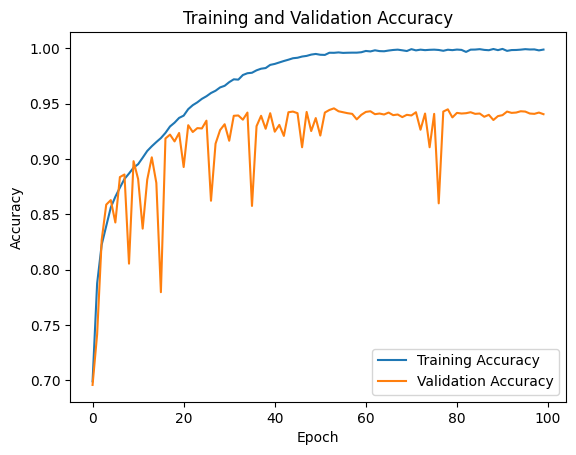

In [20]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Modified LeNet-5

In [11]:
from keras import layers
from keras import models
import pandas as pd

model_mod_lenet5 = models.Sequential()
# Layer 1: Convolutional layer with 6 filters of size 3x3, followed by Max pooling
model_mod_lenet5.add(layers.Conv2D(6, kernel_size=(3, 3), activation='relu', input_shape=(img_height,img_width,3)))
model_mod_lenet5.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Layer 2: Convolutional layer with 32 filters of size 3x3, followed by Max pooling
model_mod_lenet5.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_height,img_width,3)))
model_mod_lenet5.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Layer 3: Convolutional layer with 64 filters of size 3x3, followed by Max pooling
model_mod_lenet5.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(img_height,img_width,3)))
model_mod_lenet5.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Layer 4: Convolutional layer with 128 filters of size 3x3, followed by Max pooling
model_mod_lenet5.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(img_height,img_width,3)))
model_mod_lenet5.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Layer 5: Convolutional layer with 128 filters of size 3x3, followed by Max pooling
model_mod_lenet5.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(img_height,img_width,3)))
model_mod_lenet5.add(layers.MaxPooling2D(pool_size=(2, 2)))
# flattening the output of the conv layer after max pooling 
model_mod_lenet5.add(layers.Flatten())
#Dropout Layer
model_mod_lenet5.add(layers.Dropout(0.2))
# Layer 8: Fully connected layer with 120 neurons
model_mod_lenet5.add(layers.Dense(120, activation='relu'))
# Layer 3: Fully connected layer with  neurons
model_mod_lenet5.add(layers.Dense(84, activation='relu'))
model_mod_lenet5.add(layers.Dense(2, activation='sigmoid'))

model_mod_lenet5.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), 
                     loss='sparse_categorical_crossentropy', 
                     metrics=['accuracy'])

# Generating the summary of the model
model_mod_lenet5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 6)       168       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 6)         0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 32)        1760      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)       

In [28]:
history3 = model_mod_lenet5.fit(
            train_rescale_ds,
            batch_size=64,
            epochs=100,
            validation_data=val_rescale_ds
)

Epoch 1/100
214/214 [==============================] - 29s 130ms/step - loss: 0.5906 - accuracy: 0.7022 - val_loss: 0.5473 - val_accuracy: 0.7156
Epoch 2/100
214/214 [==============================] - 29s 137ms/step - loss: 0.4389 - accuracy: 0.8082 - val_loss: 0.4370 - val_accuracy: 0.8089
Epoch 3/100
214/214 [==============================] - 30s 140ms/step - loss: 0.3943 - accuracy: 0.8346 - val_loss: 0.3926 - val_accuracy: 0.8393
Epoch 4/100
214/214 [==============================] - 30s 141ms/step - loss: 0.3659 - accuracy: 0.8483 - val_loss: 0.3429 - val_accuracy: 0.8587
Epoch 5/100
214/214 [==============================] - 30s 141ms/step - loss: 0.3302 - accuracy: 0.8677 - val_loss: 0.3143 - val_accuracy: 0.8748
Epoch 6/100
214/214 [==============================] - 31s 144ms/step - loss: 0.2992 - accuracy: 0.8830 - val_loss: 0.3079 - val_accuracy: 0.8734
Epoch 7/100
214/214 [==============================] - 30s 142ms/step - loss: 0.2741 - accuracy: 0.8923 - val_loss: 0.4150 -

In [30]:
mod_test_loss, test_accuracy = model_mod_lenet5.evaluate(test_rescale_ds, verbose = 0)
# validation accuracy
print(f'Test Loss: {mod_test_loss}')
# test accuracy
print(f'Test Accuracy: {test_accuracy}')

Test Loss: 0.030732985585927963
Test Accuracy: 0.9943718314170837


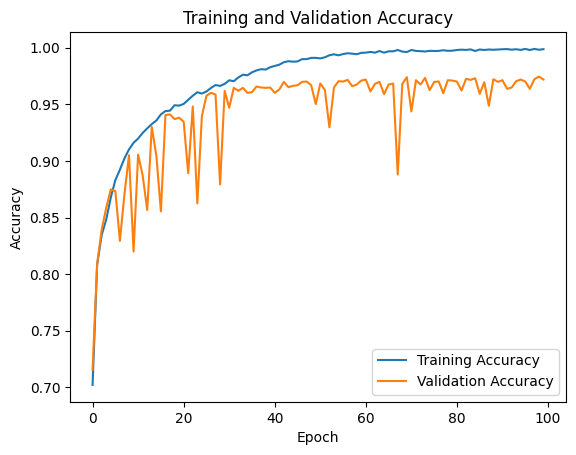

In [32]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## LeNet 5 Models without overfitting

In [12]:
history4 = model_mod_lenet5.fit(
            train_rescale_ds,
            batch_size=64,
            epochs=30,
            validation_data=val_rescale_ds
)
mod_test_loss, test_accuracy = model_mod_lenet5.evaluate(test_rescale_ds, verbose = 0)
# validation accuracy
print(f'Test Loss: {mod_test_loss}')
# test accuracy
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/30
214/214 [==============================] - 33s 148ms/step - loss: 0.6235 - accuracy: 0.6754 - val_loss: 0.5674 - val_accuracy: 0.6860
Epoch 2/30
214/214 [==============================] - 31s 143ms/step - loss: 0.4695 - accuracy: 0.7826 - val_loss: 0.3962 - val_accuracy: 0.8218
Epoch 3/30
214/214 [==============================] - 32s 148ms/step - loss: 0.4163 - accuracy: 0.8212 - val_loss: 0.3771 - val_accuracy: 0.8499
Epoch 4/30
214/214 [==============================] - 31s 145ms/step - loss: 0.3833 - accuracy: 0.8433 - val_loss: 0.3359 - val_accuracy: 0.8622
Epoch 5/30
214/214 [==============================] - 31s 144ms/step - loss: 0.3578 - accuracy: 0.8550 - val_loss: 0.3957 - val_accuracy: 0.8373
Epoch 6/30
214/214 [==============================] - 31s 146ms/step - loss: 0.3382 - accuracy: 0.8674 - val_loss: 0.3023 - val_accuracy: 0.8851
Epoch 7/30
214/214 [==============================] - 32s 148ms/step - loss: 0.3082 - accuracy: 0.8822 - val_loss: 0.2769 - val_ac

In [13]:
history5 = model_lenet5.fit(
            train_rescale_ds,
            batch_size=64,
            epochs=30,
            validation_data=val_rescale_ds
)
test_loss, test_accuracy = model_lenet5.evaluate(test_rescale_ds, verbose = 0)
# validation accuracy
print(f'Test Loss: {test_loss}')
# test accuracy
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/30
214/214 [==============================] - 22s 98ms/step - loss: 0.6243 - accuracy: 0.6738 - val_loss: 0.5682 - val_accuracy: 0.7318
Epoch 2/30
214/214 [==============================] - 21s 98ms/step - loss: 0.5514 - accuracy: 0.7360 - val_loss: 0.7544 - val_accuracy: 0.6696
Epoch 3/30
214/214 [==============================] - 21s 97ms/step - loss: 0.4910 - accuracy: 0.7824 - val_loss: 0.4516 - val_accuracy: 0.7828
Epoch 4/30
214/214 [==============================] - 21s 98ms/step - loss: 0.4530 - accuracy: 0.8040 - val_loss: 0.5676 - val_accuracy: 0.7265
Epoch 5/30
214/214 [==============================] - 21s 98ms/step - loss: 0.4359 - accuracy: 0.8131 - val_loss: 0.6259 - val_accuracy: 0.7191
Epoch 6/30
214/214 [==============================] - 21s 98ms/step - loss: 0.4189 - accuracy: 0.8266 - val_loss: 0.4744 - val_accuracy: 0.7784
Epoch 7/30
214/214 [==============================] - 21s 100ms/step - loss: 0.4035 - accuracy: 0.8339 - val_loss: 0.3872 - val_accuracy

In [17]:
model_mod_lenet5.save('modLenet5_model.keras')

method